
# Предобработка данных в pandas
В этом уроке мы пройдем полный цикл предобработки как в реальном проекте: от чтения сырых данных до готовых, предобработанных данных.


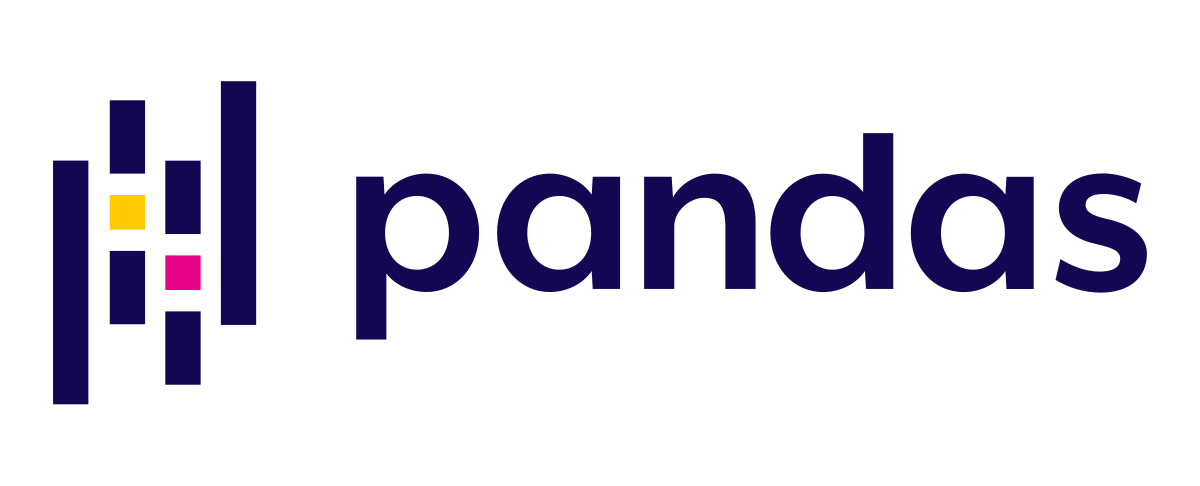

## 📘 Что разберём в ноутбуке

### **Загрузка и первичный просмотр данных**
- Размеры, первые строки, типы колонок, базовая диагностика качества.
### **Очистка датасета**

- Удаление дубликатов, проверка правдоподобности значений, простые фильтры качества.

### **Обогащение данных**

- Соединение нескольких таблиц (джойны) для расширения набора признаков.

### **Работа с пропусками**

- Разные подходы для числовых, категориальных и временных признаков.

### **Анализ данных во времени**

- Сортировка, группировки, лаги, разности, темпы изменения, окна.

### **Подготовка признаков**

- Работа с категориями, обработка экстремумов, создание дополнительных фич.



## 📝 Также: индивидуальное практическое задание

In [1]:
#  Импорт библиотек и настройка отображения pandas
# Эти параметры делают вывод таблиц более удобным:
# - отображается больше строк и столбцов
# - увеличена максимальная ширина вывода, чтобы данные не обрезались
import os
import requests
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)


## 1) Загрузка данных из репозитория

Описание основного датасета:
| №  | Поле                    | Тип                | Описание                                                                                                                                                                                                                                    |
| -- | ----------------------- | ------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 1  | **snapshot_month**      | `string (YYYY-MM)` | Месяц, за который рассчитаны показатели клиента (срез на конец месяца). Используется для временного анализа и построения таргета (например, отток в следующем месяце).                                                                      |
| 2  | **client_id**           | `string`           | Уникальный идентификатор клиента. Один и тот же клиент повторяется по месяцам (одна строка на клиента за месяц).                                                                                                                            |
| 3  | **n_contacts**          | `int`              | Общее количество коммуникаций с клиентом за месяц (звонки, SMS, e-mail и т.д.).                                                                                                                                                             |
| 4  | **n_success_calls**     | `int`              | Количество успешных звонков (состоявшихся контактов) за месяц.                                                                                                                                                                              |
| 5  | **n_fail_calls**        | `int`              | Количество неуспешных звонков (недозвоны, отказ, недоступен).                                                                                                                                                                               |
| 6  | **n_sms**               | `int`              | Количество отправленных SMS-сообщений клиенту за месяц.                                                                                                                                                                                     |
| 7  | **n_emails**            | `int`              | Количество e-mail-рассылок, доставленных клиенту за месяц.                                                                                                                                                                                  |
| 8  | **bal_min_30d**         | `float`            | Минимальный дневной баланс клиента за последние 30 дней. Показывает, насколько “проседали” средства клиента.                                                                                                                                |
| 9  | **bal_max_30d**         | `float`            | Максимальный дневной баланс клиента за последние 30 дней.                                                                                                                                                                                   |
| 10 | **bal_avg_30d**         | `float`            | Средний дневной баланс клиента за последние 30 дней. Часто используется как индикатор общей активности и платежеспособности.                                                                                                                |
| 11 | **amt_sum_30d**         | `float`            | Суммарный объём транзакций клиента за последние 30 дней. Снижение этого показателя часто предшествует оттоку.                                                                                                                               |
| 12 | **risk_score**          | `float [0–1]`      | Индекс риска клиента (рассчитанный системой скоринга). Чем выше, тем выше вероятность негативного поведения (задержки, уход, дефолт).                                                                                             |
| 13 | **engagement_score**    | `float [0–1]`      | Индекс вовлечённости клиента (на основе активности, откликов на коммуникации, логинов в приложение и т.д.). Высокое значение говорит о лояльном и активном клиенте.                                                                         |
| 14 | **days_since_last_txn** | `int`              | Количество дней с момента последней транзакции клиента. Чем больше значение, тем менее активен клиент.                                                                                                                                      |
| 15 | **is_term_deposit**     | `int {0,1}`        | Признак наличия у клиента срочного депозита (1 — есть, 0 — нет). Такие клиенты обычно более стабильны.                                                                                                                                      |
| 16 | **is_credit_active**    | `int {0,1}`        | Признак наличия активного кредита (1 — есть, 0 — нет). Клиенты с активным кредитом реже уходят.                                                                                                                                             |
| 17 | **is_mobile_app_user**  | `int {0,1}`        | Признак использования мобильного приложения банка. Активные пользователи приложения, как правило, менее склонны к оттоку.                                                                                                                   |
| 18 | **is_salary_client**    | `int {0,1}`        | Признак зарплатного клиента (получает зарплату на счёт в банке). Такие клиенты чаще остаются в банке дольше.                                                                                                                                |
| 19 | **is_churn_this_month** | `int {0,1}`        | Флаг оттока в текущем месяце. |

In [2]:
base_url = "https://raw.githubusercontent.com/totiela/stepik_simulator_ds/main/lessons/lesson_3_3/"
path_1 = '3_3_client_socdem_dirty.csv'
path_2 = '3_3_client_churn_dirty.csv'
# Скачиваем файл, если его нет
if not os.path.exists(base_url+path_1):
    r = requests.get(base_url+path_1)
    r.raise_for_status()
    with open(path_1, "wb") as f:
        f.write(r.content)

if not os.path.exists(base_url+path_2):
    r = requests.get(base_url+path_2)
    r.raise_for_status()
    with open(path_2, "wb") as f:
        f.write(r.content)

In [ ]:
# Путь к репозиторию
base_url = "https://raw.githubusercontent.com/totiela/stepik_simulator_ds/main/lessons/lesson_3_3/"

# Файлы
socdem_url = base_url + "3_3_client_socdem_dirty.csv"
churn_url  = base_url + "3_3_client_churn_dirty.csv"

# Загрузка
df_socdem = pd.read_csv(socdem_url)
df_main  = pd.read_csv(churn_url)

print("Файлы успешно загружены")
print("df_main:", df_main.shape, "| df_socdem:", df_socdem.shape)
df_main.sample(3)


Помимо этого датасета у нас есть еще один, которым мы хотим обогатить исходный датасет - это социально-демографические признаки клиента (такое часто бывает на практике, что есть базовый датасет и к нему нужно подтягивать много дополнительных датасетов), вот описание датасета:
| №  | Поле                  | Тип            | Описание                                                                                                                                                                                      |
| -- | --------------------- | -------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 1  | **client_id**         | `string`       | Уникальный идентификатор клиента. Совпадает с `client_id` из основного churn-датасета, используется для объединения (`merge`) данных о поведении и соцдем-характеристиках.                    |
| 2  | **gender**            | `string {M,F}` | Пол клиента: `M` — мужской, `F` — женский. Может использоваться для анализа различий в поведении и сегментации клиентов.                                                                      |
| 3  | **age**               | `int`          | Возраст клиента (полных лет) на момент последнего обновления профиля. Используется для построения возрастных групп и возрастных фичей.                                                        |
| 4  | **region**            | `string`       | Регион проживания или регистрации клиента (например, *Moscow*, *Kazan*, *Sochi*). Применяется при географической сегментации и анализе региональных различий в активности.                    |
| 5  | **income_monthly**    | `float`        | Средний ежемесячный доход клиента (в рублях). Может использоваться для построения признаков уровня благосостояния, расчёта показателей affordability и прогнозирования финансового поведения. |
| 6  | **profession**        | `string`       | Профессия клиента (например, *Engineer*, *Teacher*, *IT Specialist*). Может влиять на доход, стабильность, финансовые привычки и восприимчивость к продуктам.                                 |
| 7  | **client_type**       | `string`       | Тип клиента в сегментации банка: *Retail*, *Premium* или *Business*. Отражает уровень обслуживания и потенциальную ценность клиента.                                                          |
| 8  | **marital_status**    | `string`       | Семейное положение клиента: *Single*, *Married*, *Divorced*, *Widowed*. Используется для демографического анализа и персонализации коммуникаций.                                              |
| 9  | **has_children**      | `int {0,1}`    | Признак наличия детей: `1` — есть дети, `0` — нет. Может влиять на финансовые приоритеты (например, кредиты, депозиты, страховки).                                                            |
| 10 | **years_with_bank**   | `int`          | Количество лет сотрудничества клиента с банком. Используется как показатель лояльности и "возраста клиента" в системе, важен при анализе удержания.                                           |
| 11 | **education_level**   | `string`       | Уровень образования клиента: *Secondary*, *Bachelor*, *Master*, *PhD*. Может коррелировать с доходом, вовлечённостью и типом используемых продуктов.                                          |
| 12 | **preferred_channel** | `string`       | Основной канал взаимодействия клиента с банком: *Mobile App*, *Website*, *Branch*, *Call Center*. Применяется при анализе цифровой активности и выборе оптимального канала коммуникации.      |


In [ ]:
df_socdem.sample(3)

## 2) 🔎 Первичный осмотр данных

* Проверим структуру таблицы и типы колонок
* Посмотрим базовые статистики и распределение пропусков
* Преобразуем даты в корректный формат `datetime`




In [ ]:
df_main.info()

In [ ]:
# количество пропусков для каждого столбца
df_main.isnull().sum()

In [ ]:
df_main.describe(include='all').T.head(20)

In [ ]:
# Дата
from pandas.tseries.offsets import MonthEnd

# привести к datetime
df_main['snapshot_month'] = pd.to_datetime(df_main['snapshot_month'])

# заменить на последний день месяца
df_main['snapshot_month'] = df_main['snapshot_month'] + MonthEnd(0)

# сортировка
df_main = df_main.sort_values(['client_id','snapshot_month']).reset_index(drop=True)

df_main.head(3)



## 3) 🧹 Чистка и базовые проверки качества
- Явные дубликаты строк
- Правдоподобность значений (минимумы/максимумы)
- Базовые фильтры (например, отрицательных балансов быть не должно)


In [ ]:
# Проверка и удаление дубликатов

# Проверяем количество дубликатов по ключу (client_id + snapshot_month)
dup_cnt = df_main.duplicated(subset=['client_id', 'snapshot_month']).sum()
print(f'Найдено дубликатов: {dup_cnt}')

In [ ]:
# Удаляем дубликаты
if dup_cnt > 0:
    df_main = df_main.drop_duplicates(subset=['client_id', 'snapshot_month'])
    print('Дубликаты удалены.')

# Подтверждаем, что дубликатов не осталось
df_main[['client_id', 'snapshot_month']].duplicated().sum()


In [ ]:
# Sanity-check значений

# Проверяем отрицательные значения в числовых метриках
cols_to_check = ['bal_min_30d', 'bal_max_30d', 'bal_avg_30d', 'amt_sum_30d']

for col in cols_to_check:
    neg_count = (df_main[col] < 0).sum()
    print(f'Отрицательных значений в {col}: {neg_count}')

    # Простая стратегия обработки: заменить на NaN
    if neg_count > 0:
        df_main.loc[df_main[col] < 0, col] = np.nan
        print(f'Значения < 0 в {col} заменены на NaN')


In [ ]:
df_main.sample(3)



## 4) 🔗 Соединение источников данных (`merge`)

Теперь присоединим socdem-таблицу (демография / профиль клиента) к основной витрине по `client_id`.

### Как работает `merge` в двух словах:

* **Берём основной датафрейм** (`df_main`) — к нему «приклеиваем» данные.
* **Указываем таблицу, которую добавляем** (у нас — `df_socdem`).
* Параметр **`how` работает как JOIN в SQL**:

  * `left` — оставляем всех клиентов из основной таблицы, даже если нет socdem;
  * `inner` — только пересечение (опасно — можно случайно сузить базу);
* В проде важно: **предобработка данных при инференсе должна совпадать с обучением**, поэтому лучше не отбрасывать клиентов из-за отсутствия socdem → используем **`how="left"`**.




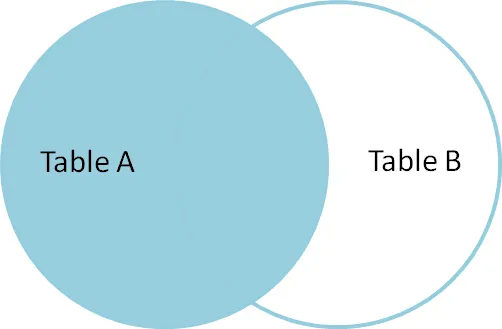

In [ ]:
df_main.isnull().sum()

In [ ]:
# удалим записи без id пользователей - без этого не получится merge

df_main = df_main.dropna(subset=['client_id'])

In [ ]:
# мерджим клиентов к исходной таблице

full_df = df_main.merge(df_socdem, on='client_id', how='left')

In [ ]:
full_df.shape[0], df_main.shape[0]

Ошибка, которая говорит, что во втором датафрейме есть дубликаты по *client_id* !!!

In [ ]:
# убираем дубликаты по client_id, оставляя первую строку в случае дубликата

df_socdem = df_socdem.drop_duplicates(subset=['client_id'], keep='first')

In [ ]:
# мерджим клиентов еще раз и проверяем результат

full_df = df_main.merge(df_socdem, on='client_id', how='left')

full_df.shape[0], df_main.shape[0]

In [ ]:
full_df

Теперь все склеилось идеально! ⚡


## 5) 🧩 Работа с пропусками: общая стратегия

В разных типах признаков пропуски обрабатываются по-разному:

* **Числовые:** медиана / среднее / специальное значение
* **Категориальные:** отдельная категория `Unknown`
* **Даты:** обычно *не заполняем* — лучше оставить как есть или удалить строки, если критично




In [ ]:
# «Волшебная» проверка колонок
full_df.select_dtypes(include='number').columns.to_list()

In [ ]:
# Группы признаков по типам
num_cols  = full_df.select_dtypes(include='number').columns.tolist()
cat_cols  = full_df.select_dtypes(include=['object', 'category']).columns.tolist()
date_cols = ['snapshot_month']

In [ ]:
# обработка категориальных признаков

# не включаем client_id в обработку
cat_cols_for_processing = [c for c in cat_cols if c != 'client_id']

for col in cat_cols_for_processing:
    # заполняем пропуски Unknown и переводим в категорию
    full_df[col] = full_df[col].fillna('Unknown').astype('category')


In [ ]:
# обработка числовых признаков

num_cols_to_process = [c for c in num_cols if c != 'is_churn_this_month']

for col in num_cols_to_process:
    # заполним пропуски медианой
    full_df[col] = full_df[col].fillna(full_df[col].median())

In [ ]:
full_df.info()


## 6) 📈 Фичи во времени: `shift` / `diff` / `rolling`

Временные признаки помогают моделям ловить **динамику поведения клиента** — растёт баланс, падает, стабилен ли он, и т.д.

Мы создадим несколько ключевых time-series фичей:

### Что добавляем

* **`target_churn_next`** — ушёл ли клиент в *следующем* месяце
* **`bal_diff_1m`** — изменение среднего баланса к предыдущему месяцу
* **`bal_pct_1m`** — процентное изменение
* **`bal_roll3_mean`** — скользящее среднее баланса за 3 месяца


In [ ]:
# таргет на следующий месяц
# у каждой строки будет значение churn следующего месяца для того же клиента. Важно: это будет NaN для последней записи группы.
full_df['target_churn_next'] = (
    full_df.groupby('client_id')['is_churn_this_month']
      .shift(-1)
)

In [ ]:
# динамики
# разница баланса за 1 месяц
full_df['bal_diff_1m'] = full_df.groupby('client_id')['bal_avg_30d'].diff()

# процентное изменение баланса за 1 месяц
full_df['bal_pct_1m']  = full_df.groupby('client_id')['bal_avg_30d'].pct_change()

In [ ]:
full_df['bal_roll3_mean'] = (
    full_df.groupby('client_id')['bal_avg_30d']
      .rolling(window=3, min_periods=1).mean()
      .reset_index(level=0, drop=True)
)

full_df[['client_id','snapshot_month','is_churn_this_month','target_churn_next','bal_avg_30d','bal_diff_1m','bal_roll3_mean']].head(6)


## 7) 🛠 Подготовка табличных признаков: категории, бинарные флаги, биннинг и простая инженерия
В этом шаге приводим категориальные и числовые данные к удобному виду: создаём бинарные признаки, делаем ручные маппинги, бьём доход на интервалы, обрезаем экстремумы и добавляем несколько информативных производных фич.



In [ ]:
print(full_df['client_type'].value_counts(dropna=False))

In [ ]:
# Быстрые бинарные признаки

full_df['is_premium'] = (full_df['client_type'].astype(str) == 'Premium').astype(int)
full_df['is_business'] = (full_df['client_type'].astype(str) == 'Business').astype(int)
full_df['is_app_primary'] = (full_df['preferred_channel'].astype(str) == 'Mobile App').astype(int)
full_df['is_website_user'] = (full_df['preferred_channel'].astype(str) == 'Website').astype(int)


In [ ]:
# маппинги категорий

if 'marital_status' in full_df.columns:
    marital_map = {
        'Single': 0,
        'Married': 1,
        'Divorced': 2,
        'Widowed': 3
    }
    full_df['marital_status_num'] = (
        full_df['marital_status']
              .map(marital_map)
              .astype('Int64')
    )


In [ ]:
# Биннинг дохода (qcut)

full_df['income_decile'] = pd.qcut(
            full_df['income_monthly'],
            q=10,
            labels=False,
            duplicates='drop'
        )


In [ ]:
full_df['income_decile'].value_counts()

In [ ]:
# Обрезка экстремальных значений (1–99 перцентили)

lower = full_df['income_monthly'].quantile(0.01)
upper = full_df['income_monthly'].quantile(0.99)

full_df['income_monthly_clipped'] = full_df['income_monthly'].clip(lower, upper)

In [ ]:
# apply для кастомной логики

# Флаг "высокого дохода"
def is_high_income(x):
    if pd.isna(x):
        return 0
    return int(x > 100_000)

full_df['is_high_income'] = full_df['income_monthly'].apply(is_high_income)

In [ ]:
cols_to_show = [
    'client_id', 'client_type', 'preferred_channel',
    'income_monthly', 'income_monthly_clipped',
    'income_decile', 'is_high_income'
]

full_df[cols_to_show].sample(6, random_state=42)



## 🧪 Задания для закрепления



**Задание 1. Easy**

Создай бинарную фичу is_inactive_long, которая показывает,
что клиент не совершал транзакции более 45 дней (days_since_last_txn > 45).

In [ ]:
# ваш код
full_df['is_inactive_long'] =

**Вопрос 1**: у какой доли клиентов с оттоком (target_churn_next = 1) этот флаг равен 1?

Ответ приведите в виде числа от 0 до 1, округлив до 3 знаков после запятой -> ответ внести в stepik

In [ ]:
# ваш код

**Задание 2. Medium**

Описание:
Создай фичу `age_group` на основе колонки `age` по следующему маппингу:

+ 18–25 → '18-25'

+ 26–35 → '26-35'

+ 36–45 → '36-45'

+ 46+ → '46+'

In [ ]:
def age_to_group(age):
  # ваш код


full_df['age_group'] = # ваш код

**Вопрос 2**:
На сколько записей возрастной группы '36-45' больше, чем '18-25'?

 -> ответ внести в stepik

In [ ]:
# ваш код


Задание 3. Hard

Построй для каждого клиента сумму транзакций (amt_sum_30d) за последние 3 и 6 месяцев.

In [ ]:
# Убедимся, что даты и сортировка корректны
full_df['snapshot_month'] = pd.to_datetime(full_df['snapshot_month'])
full_df = full_df.sort_values(['client_id', 'snapshot_month'])

# Rolling суммы на 3 и 6 месяцев
full_df['amt_sum_roll3'] = (
    # ваш код
)

full_df['amt_sum_roll6'] = (
    # ваш код
)

**Вопрос 3**: на сколько корреляция суммы транзакций за 3 месяца (`amt_sum_roll3`) с таргетом (`target_churn_next`) больше, чем сумма транзакций за 6 месяцев (`amt_sum_roll6`)?

Округли до 4 знаков после запятой. -> ответ внести в stepik

In [ ]:
# ваш код